Import necessary libraries

In [119]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.frequent_patterns import apriori, association_rules
import datetime as dt

Load the dataset

In [120]:
url = "Online Retail.xlsx"
df = pd.read_excel(url, sheet_name='Online Retail')  # Load the dataset from the Excel file

Initial data inspection

In [121]:
print(df.info())  # Check the structure of the dataset (columns, data types, non-null counts)
print(df.head())  # Display the first 5 rows of the dataset
print(df.isnull().sum())  # Check for missing values in each column

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB
None
  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    

Data Cleaning<br>
Remove rows where InvoiceNo is missing

In [122]:
df.dropna(subset=['InvoiceNo'], inplace=True)

Convert InvoiceNo to string (in case it contains non-numeric characters)

In [123]:
df['InvoiceNo'] = df['InvoiceNo'].astype(str)

Remove rows where InvoiceNo starts with 'C' (these are canceled orders)

In [124]:
df = df[~df['InvoiceNo'].str.startswith('C')]

Convert InvoiceDate to datetime format

In [125]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

Check the dataset after cleaning

In [126]:
print(df.info())
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
Index: 532621 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    532621 non-null  object        
 1   StockCode    532621 non-null  object        
 2   Description  531167 non-null  object        
 3   Quantity     532621 non-null  int64         
 4   InvoiceDate  532621 non-null  datetime64[ns]
 5   UnitPrice    532621 non-null  float64       
 6   CustomerID   397924 non-null  float64       
 7   Country      532621 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 36.6+ MB
None
InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     134697
Country             0
dtype: int64


Feature Engineering: Calculate TotalSales for each transaction

In [127]:
df['TotalSales'] = df['Quantity'] * df['UnitPrice']

Exploratory Data Analysis (EDA)

1. Total Sales Analysis

In [128]:
total_sales = df['TotalSales'].sum()  # Calculate total sales
print(f"Total Sales: ${total_sales:.2f}")

Total Sales: $10644560.42


Monthly Sales Analysis

In [129]:
df['Month'] = df['InvoiceDate'].dt.to_period('M')  # Extract month from InvoiceDate
monthly_sales = df.groupby('Month')['TotalSales'].sum()  # Calculate monthly sales

Plot Monthly Sales

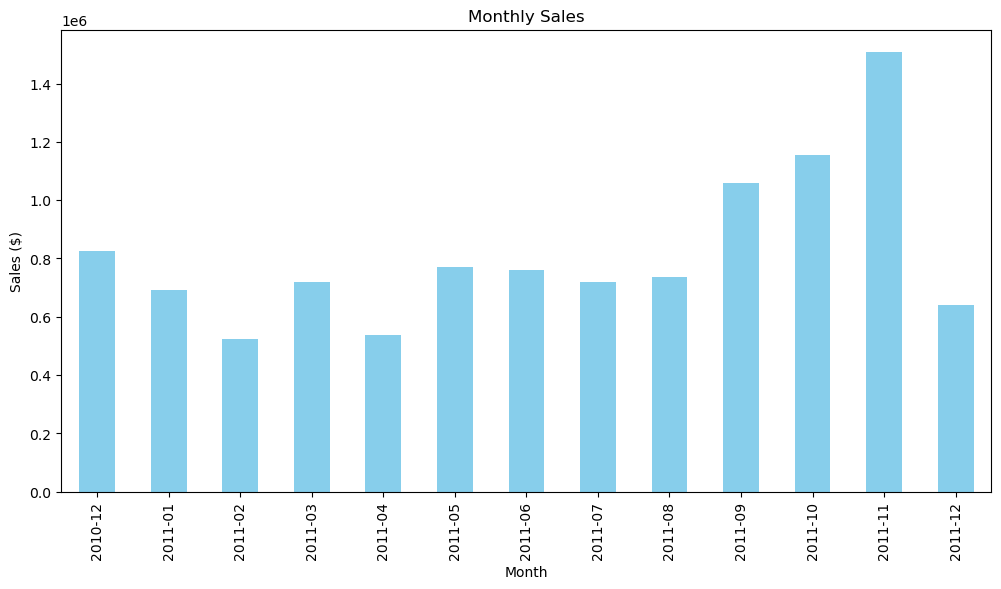

In [130]:
plt.figure(figsize=(12, 6))
monthly_sales.plot(kind='bar', color='skyblue')
plt.title('Monthly Sales')
plt.xlabel('Month')
plt.ylabel('Sales ($)')
plt.show()

2. Customer Behavior Analysis<br>
Identify top customers by number of purchases

In [131]:
customer_purchase_count = df.groupby('CustomerID')['InvoiceNo'].nunique().sort_values(ascending=False)
top_customers = customer_purchase_count.head(10)  # Top 10 customers

Plot Top Customers

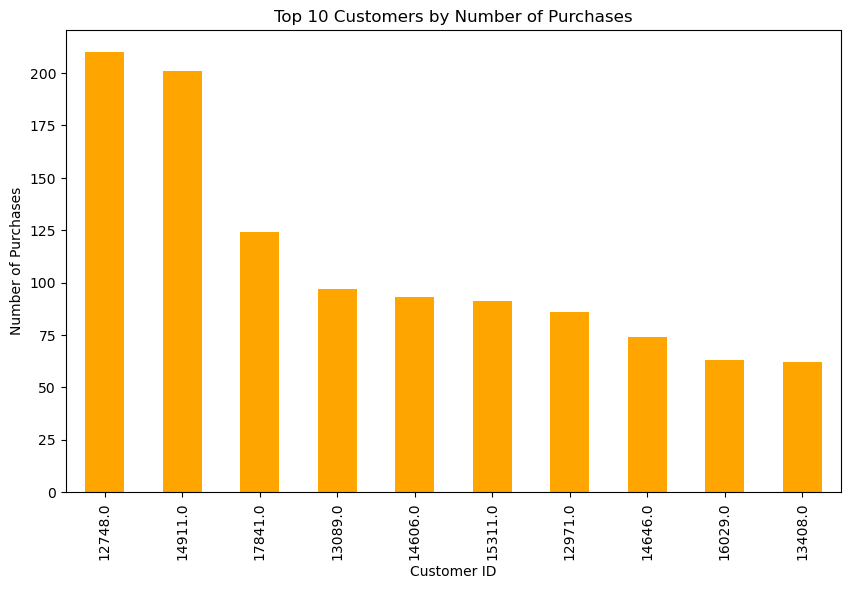

In [132]:
plt.figure(figsize=(10, 6))
top_customers.plot(kind='bar', color='orange')
plt.title('Top 10 Customers by Number of Purchases')
plt.xlabel('Customer ID')
plt.ylabel('Number of Purchases')
plt.show()

3. Product Analysis<br>
Identify top-selling products by total sales

In [133]:
product_sales = df.groupby('Description')['TotalSales'].sum().sort_values(ascending=False)
top_products = product_sales.head(10)  # Top 10 products

Plot Top Products

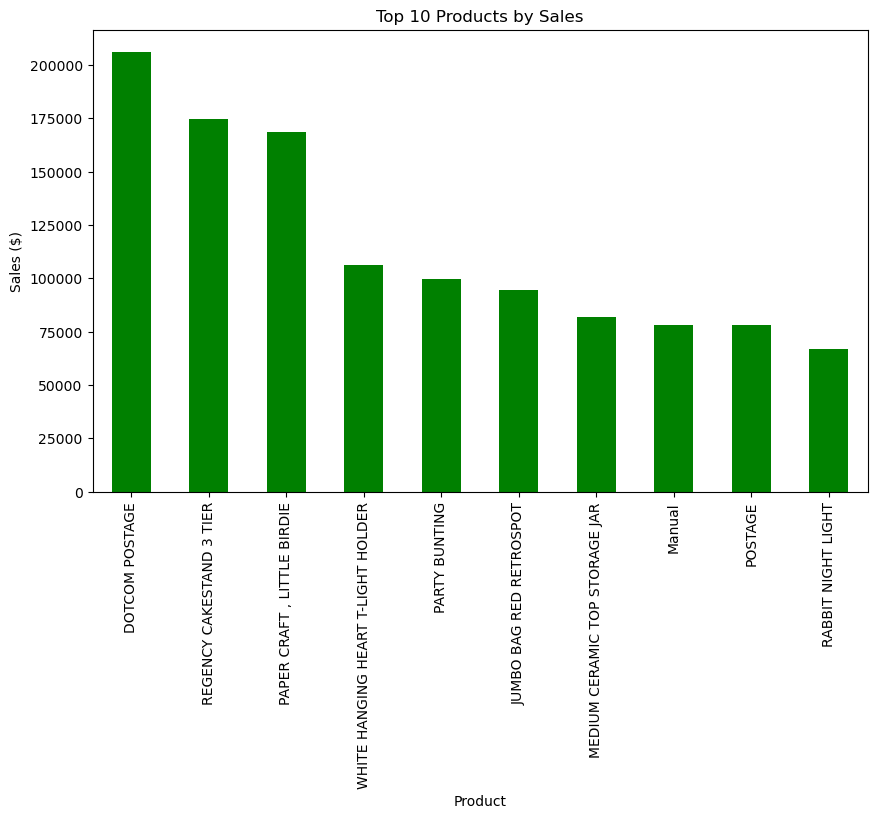

In [134]:
plt.figure(figsize=(10, 6))
top_products.plot(kind='bar', color='green')
plt.title('Top 10 Products by Sales')
plt.xlabel('Product')
plt.ylabel('Sales ($)')
plt.show()

4. Geographic Analysis<br>
Analyze sales by country

In [135]:
country_sales = df.groupby('Country')['TotalSales'].sum().sort_values(ascending=False)
top_countries = country_sales.head(10)  # Top 10 countries by sales

Plot Sales by Country

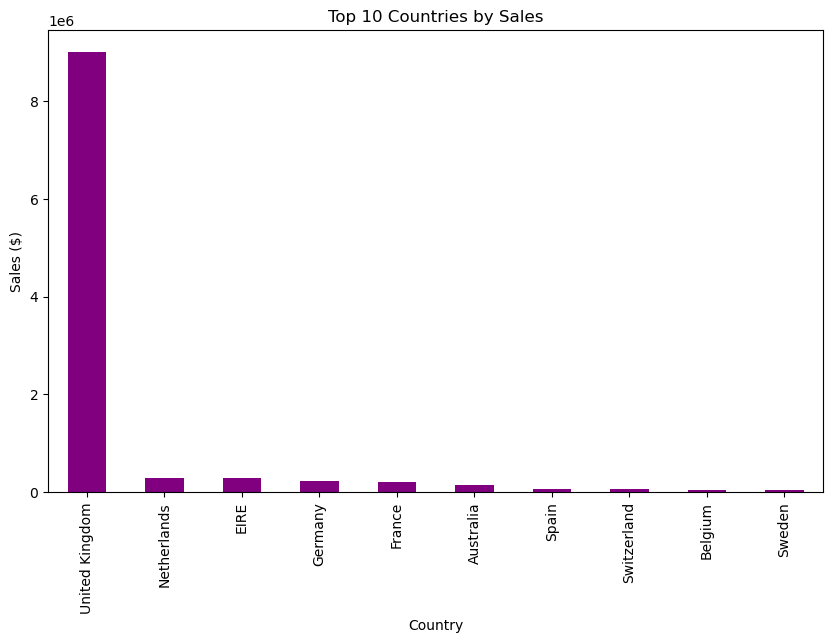

In [136]:
plt.figure(figsize=(10, 6))
top_countries.plot(kind='bar', color='purple')
plt.title('Top 10 Countries by Sales')
plt.xlabel('Country')
plt.ylabel('Sales ($)')
plt.show()

Advanced Analysis

1. RFM Analysis (Recency, Frequency, Monetary)<br>
Set a reference date for recency calculation (e.g., one day after the last invoice date)

In [137]:
reference_date = df['InvoiceDate'].max() + dt.timedelta(days=1)

Calculate RFM metrics

In [138]:
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',  # Frequency
    'TotalSales': 'sum'  # Monetary
})

Rename columns

In [139]:
rfm.rename(columns={
    'InvoiceDate': 'Recency',
    'InvoiceNo': 'Frequency',
    'TotalSales': 'Monetary'
}, inplace=True)

Segment customers based on RFM scores<br>
Assign scores from 1 to 4 (4 is the best)

In [140]:
# rfm['RecencyScore'] = pd.qcut(rfm['Recency'], 4, labels=[4, 3, 2, 1])
# rfm['FrequencyScore'] = pd.qcut(rfm['Frequency'], 4, labels=[1, 2, 3, 4])
# rfm['MonetaryScore'] = pd.qcut(rfm['Monetary'], 4, labels=[1, 2, 3, 4])
# 
# 
# 
# Alternatively, use pd.cut if pd.qcut fails
rfm['RecencyScore'] = pd.cut(rfm['Recency'], bins=4, labels=[4, 3, 2, 1])
rfm['FrequencyScore'] = pd.cut(rfm['Frequency'], bins=4, labels=[1, 2, 3, 4])
rfm['MonetaryScore'] = pd.cut(rfm['Monetary'], bins=4, labels=[1, 2, 3, 4])

Calculate RFM score

In [141]:
rfm['RFM_Score'] = rfm['RecencyScore'].astype(int) + rfm['FrequencyScore'].astype(int) + rfm['MonetaryScore'].astype(int)

Segment customers based on RFM score

In [142]:
# rfm['Segment'] = pd.qcut(rfm['RFM_Score'], 3, labels=['Low', 'Medium', 'High'])
# 
# 
# 
rfm['Segment'] = pd.cut(rfm['RFM_Score'], bins=3, labels=['Low', 'Medium', 'High'])

Plot RFM segments

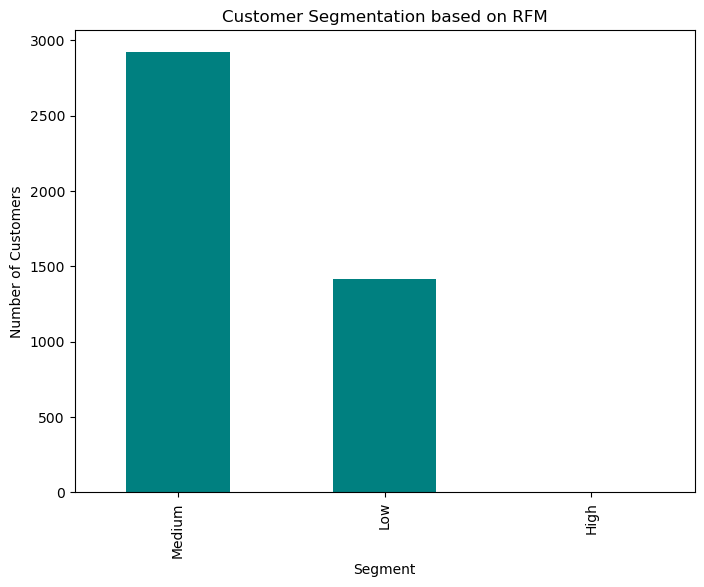

In [143]:
plt.figure(figsize=(8, 6))
rfm['Segment'].value_counts().plot(kind='bar', color='teal')
plt.title('Customer Segmentation based on RFM')
plt.xlabel('Segment')
plt.ylabel('Number of Customers')
plt.show()

2. Market Basket Analysis<br>
Create a transaction matrix (each row represents a transaction, and each column represents a product)

In [144]:
transaction_matrix = df.groupby(['InvoiceNo', 'Description'])['Quantity'].sum().unstack().fillna(0)

Convert quantities to binary values (1 if purchased, 0 otherwise)

In [145]:
# transaction_matrix = transaction_matrix.applymap(lambda x: 1 if x > 0 else 0)
# 
# 
# 
transaction_matrix = transaction_matrix.map(lambda x: 1 if x > 0 else 0)

Find frequent itemsets

In [146]:
# Convert quantities to boolean values (True if purchased, False otherwise)
transaction_matrix = transaction_matrix.map(lambda x: x > 0)

# Find frequent itemsets
frequent_itemsets = apriori(transaction_matrix, min_support=0.01, use_colnames=True)


Generate association rules

In [147]:
rules = association_rules(frequent_itemsets, metric='lift', min_threshold=0.5)


Plot the rules

2816 rules were generated.


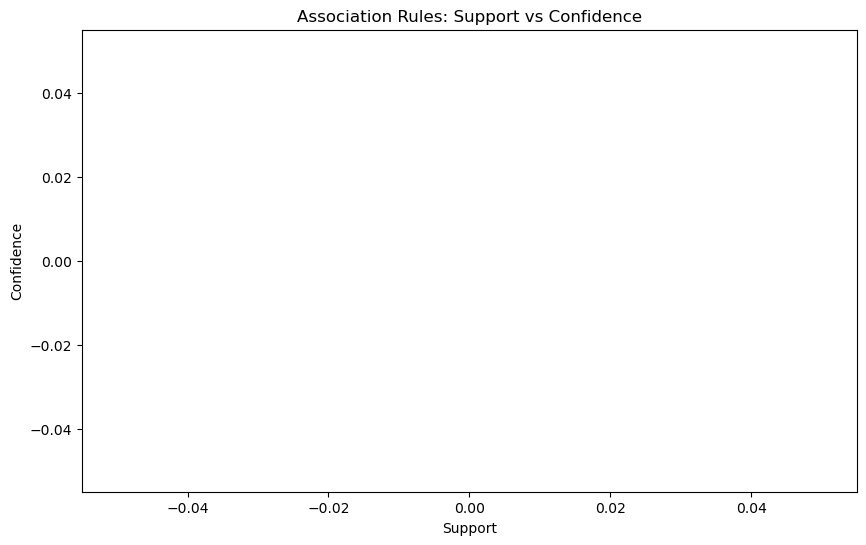

In [148]:

# Check if rules are generated
if rules.empty:
    print("No rules were generated. Try reducing min_support or min_threshold.")
else:
    print(f"{len(rules)} rules were generated.")

    # Filter rules for better visualization
    filtered_rules = rules[(rules['support'] > 0.05) & (rules['confidence'] > 0.5)]

    # Plot the rules
    plt.figure(figsize=(10, 6))
    plt.scatter(filtered_rules['support'], filtered_rules['confidence'], alpha=0.5)
    plt.title('Association Rules: Support vs Confidence')
    plt.xlabel('Support')
    plt.ylabel('Confidence')
    plt.show()

3. Time-Based Analysis<br>
Extract hour and day of week from InvoiceDate

In [149]:
df['Hour'] = df['InvoiceDate'].dt.hour
df['DayOfWeek'] = df['InvoiceDate'].dt.day_name()

Analyze sales by hour

In [150]:
hourly_sales = df.groupby('Hour')['TotalSales'].sum()

Plot hourly sales

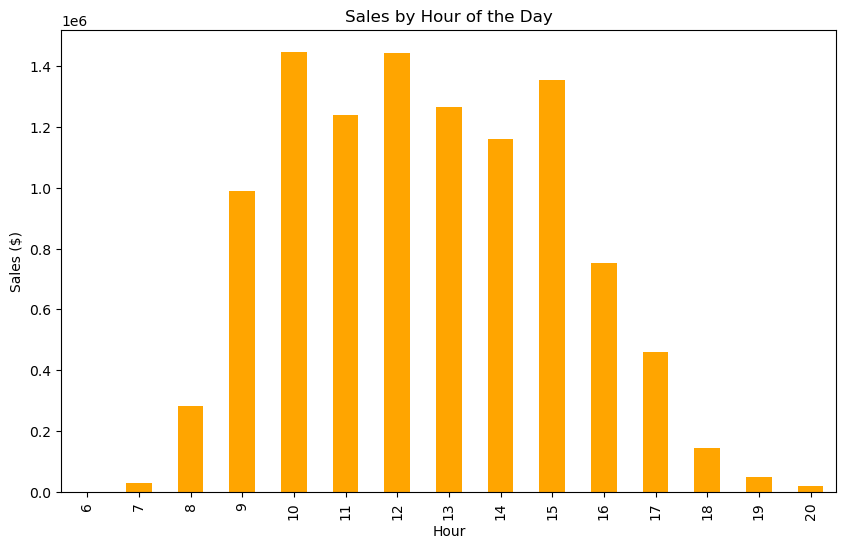

In [151]:
plt.figure(figsize=(10, 6))
hourly_sales.plot(kind='bar', color='orange')
plt.title('Sales by Hour of the Day')
plt.xlabel('Hour')
plt.ylabel('Sales ($)')
plt.show()

Analyze sales by day of week

In [152]:
day_of_week_sales = df.groupby('DayOfWeek')['TotalSales'].sum()

Plot sales by day of week

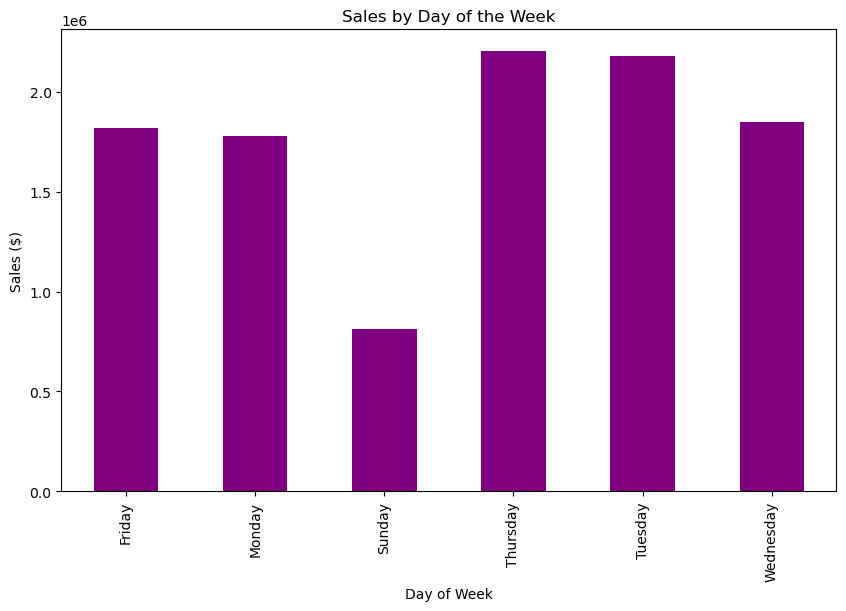

In [153]:
plt.figure(figsize=(10, 6))
day_of_week_sales.plot(kind='bar', color='purple')
plt.title('Sales by Day of the Week')
plt.xlabel('Day of Week')
plt.ylabel('Sales ($)')
plt.show()

4. Loyal Customers Analysis<br>
Identify loyal customers (e.g., top 10% of customers by frequency and monetary value)

In [154]:
loyal_customers = rfm[rfm['Segment'] == 'High']

Analyze the purchasing behavior of loyal customers

In [155]:
loyal_customer_data = df[df['CustomerID'].isin(loyal_customers.index)]

Top products bought by loyal customers

In [156]:
loyal_top_products = loyal_customer_data.groupby('Description')['TotalSales'].sum().sort_values(ascending=False).head(10)

Plot top products bought by loyal customers

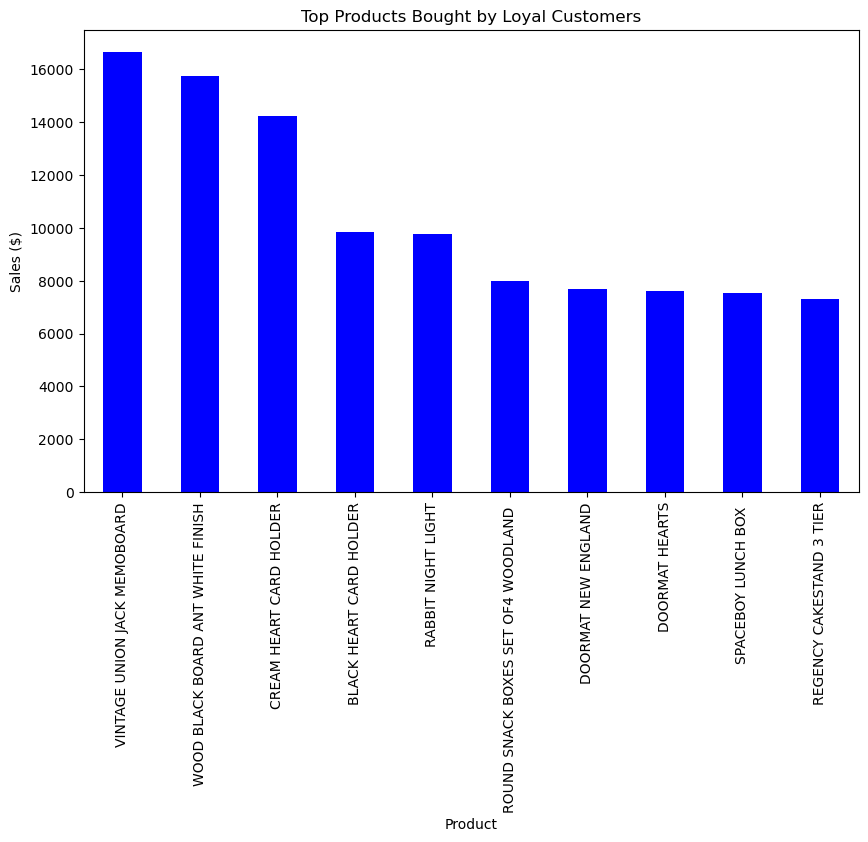

In [157]:
plt.figure(figsize=(10, 6))
loyal_top_products.plot(kind='bar', color='blue')
plt.title('Top Products Bought by Loyal Customers')
plt.xlabel('Product')
plt.ylabel('Sales ($)')
plt.show()

Key Insights

In [158]:
print("Key Insights:")
print(f"1. Total Sales: ${total_sales:.2f}")
print(f"2. Month with Highest Sales: {monthly_sales.idxmax()} with ${monthly_sales.max():.2f}")
print(f"3. Top Customer: {top_customers.idxmax()} with {top_customers.max()} purchases")
print(f"4. Top Product: {top_products.idxmax()} with ${top_products.max():.2f} in sales")
print(f"5. Top Country: {top_countries.idxmax()} with ${top_countries.max():.2f} in sales")
print(f"6. Number of Loyal Customers: {len(loyal_customers)}")

Key Insights:
1. Total Sales: $10644560.42
2. Month with Highest Sales: 2011-11 with $1509496.33
3. Top Customer: 12748.0 with 210 purchases
4. Top Product: DOTCOM POSTAGE with $206248.77 in sales
5. Top Country: United Kingdom with $9003097.96 in sales
6. Number of Loyal Customers: 4
